In [133]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load Model

In [134]:
classifier_model = torch.load('best_G5_classifier.pt', map_location=torch.device('cpu')) # We trained the model on gpu but will use on cpu
classifier_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Transform Images

In [135]:
# Transform images into our input format
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Read class names from txt
with open('class_names.txt', 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# Predict

In [142]:
def predict_garbage(my_image_path):
    image_path = my_image_path
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # To add batch size we use unsqueze

    # Give image to the model
    with torch.no_grad():
        output = classifier_model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        predicted_class = class_names[predicted.item()]
        confidence_percentage = confidence.item() * 100


    print(f'The model predicts this image as: {predicted_class} ({confidence_percentage:.2f}%) \n')


    # Collect class names and probabilities
    class_probs = [(class_names[i], prob.item() * 100) for i, prob in enumerate(probabilities[0])]
    
    # Sort class probabilities from highest to lowest
    class_probs.sort(key=lambda x: x[1], reverse=True)

    # Prepare text lines with sorted probabilities
    text_lines = []
    for class_name, prob_percentage in class_probs:
        text_lines.append(f'{class_name}: {prob_percentage:.2f}%')
        print(f'{class_name}: {prob_percentage:.2f}%')

    # Show original image and predicted image on PIL format
    image_pil_original = image

    image_tensor = image_tensor / 2 + 0.5
    image_pil_predicted = transforms.ToPILImage()(image_tensor.squeeze(0))

    # Resize predicted image to match original image size
    image_pil_predicted = image_pil_predicted.resize(image_pil_original.size, Image.BICUBIC)

    # Add prediction text to the predicted image
    draw = ImageDraw.Draw(image_pil_predicted)
    font = ImageFont.load_default()

    # Define text and its position
    text_position = (10, 10)
    for line in text_lines:
        text_bbox = draw.textbbox(text_position, line, font=font)
        
        draw.rectangle(text_bbox, fill="white")
        draw.text(text_position, line, fill="black", font=font)
        text_position = (text_position[0], text_position[1] + text_bbox[3] - text_bbox[1] + 5)

    # Display images side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    ax[0].imshow(image_pil_original)
    ax[0].axis('off')
    ax[0].set_title("Original Image")

    ax[1].imshow(image_pil_predicted)
    ax[1].axis('off')
    ax[1].set_title(f"The model predicts this image as: {predicted_class} ({confidence_percentage:.2f}%)")

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()
    


The model predicts this image as: Glass (99.56%) 

Glass: 99.56%
Plastic: 0.44%
Metal: 0.00%
Trash: 0.00%
Cardboard: 0.00%
Paper: 0.00%


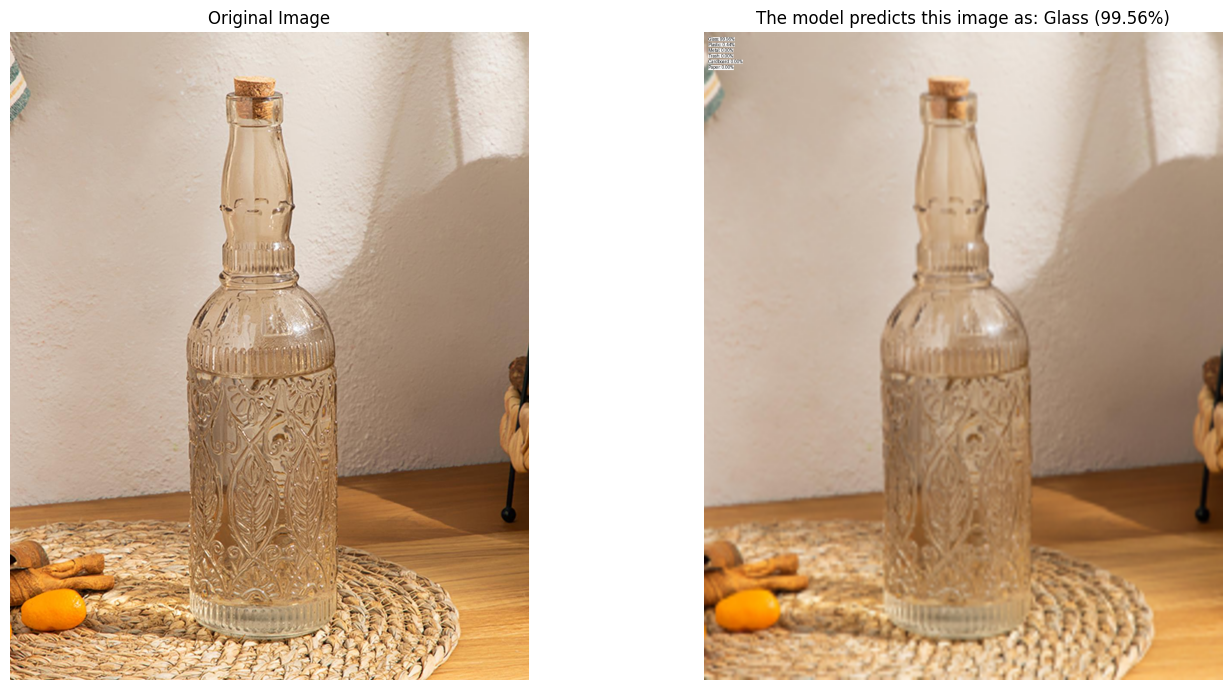

<Figure size 640x480 with 0 Axes>

In [143]:
predict_garbage('Test/camsise.jpg')